In [22]:
import os
import numpy as np

# Paths to VOC directories
base_dir = '/Volumes/T7-apps/aml_dataset//VOC2012_train_val/VOC2012_train_val'
images_dir = os.path.join(base_dir, 'JPEGImages')
annotations_dir = os.path.join(base_dir, 'Annotations')
sets_dir = os.path.join(base_dir, 'ImageSets/Main')

# Function to read predefined splits
def get_files_from_split(file_path):
    with open(file_path, 'r') as f:
        files = [x.strip().split()[0] for x in f.readlines() if not x.startswith('#')]
    return files

# Get all files from trainval.txt
trainval_files = get_files_from_split(os.path.join(sets_dir, 'trainval.txt'))
np.random.shuffle(trainval_files)  # Shuffle to randomize the split

split_index = int(len(trainval_files) * 0.9)
train_files = trainval_files[:split_index]
val_files = trainval_files[split_index:]


In [23]:
from torch.utils.data import Dataset
from PIL import Image
import os
import random
from torchvision import transforms

class RotationDataset(Dataset):
    def __init__(self, file_list, root_dir, transform=None):
        """
        file_list: lista dei nomi dei file (es. ['2008_000001', ...])
        root_dir: cartella dove sono le immagini JPEG
        """
        self.file_list = file_list
        self.root_dir = root_dir
        self.transform = transform
        
        # Mappa le rotazioni in classi
        self.angle_to_label = {0: 0, 90: 1, 180: 2, 270: 3}

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        filename = self.file_list[idx]
        img_path = os.path.join(self.root_dir, filename + ".jpg")
        
        image = Image.open(img_path).convert("RGB")
        
        # 1. Scegliamo una rotazione casuale
        angle = random.choice([0, 90, 180, 270])
        
        # 2. Ruotiamo l'immagine
        # Nota: expand=True adatta la dimensione se l'img non è quadrata
        rotated_image = image.rotate(-angle, expand=True) 
        
        # 3. Creiamo la label per la rotazione
        label_rotation = self.angle_to_label[angle]
        
        # 4. Applichiamo le trasformazioni standard (Resize, ToTensor, Normalize)
        if self.transform:
            rotated_image = self.transform(rotated_image)
            
        return rotated_image, label_rotation

# Esempio di utilizzo
transform_pipeline = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Usa la tua lista 'train_files' generata nel tuo codice precedente
train_dataset = RotationDataset(train_files, images_dir, transform=transform_pipeline)

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models
import time
import copy

# --- 1. CONFIGURAZIONE ---
BATCH_SIZE = 32
NUM_EPOCHS = 50
LEARNING_RATE = 0.01
PATIENCE = 7
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Usando device: {DEVICE}")

# --- 2. DATALOADERS ---
# Creiamo il dataset di validazione (assicurati di aver definito val_files come prima)
val_dataset = RotationDataset(val_files, images_dir, transform=transform_pipeline)

# Creiamo i generatori di batch
# --- 2. DATALOADERS ---
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# --- 3. DEFINIZIONE DEL MODELLO ---
# Scarichiamo una ResNet18 pre-addestrata
model = models.resnet18(weights = None)

# Congeliamo i pesi (facoltativo, ma velocizza se hai pochi dati)
# per un task semplice come la rotazione, spesso conviene NON congelare tutto, 
# ma se vuoi farlo:
#for param in model.parameters():
#     param.requires_grad = False

# Modifichiamo l'ultimo layer (Fully Connected) per avere 4 output (0, 90, 180, 270)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)
model = model.to(DEVICE)

# --- 4. LOSS E OPTIMIZER ---
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS)


# --- 5. FUNZIONE DI TRAINING CON EARLY STOPPING ---
def train_model_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=25, patience=5):
    start_time = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    epochs_no_improve = 0  # Contatore per l'early stopping
    
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Ogni epoca ha una fase di training e una di validazione
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloader:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.item() / len(dataloader.dataset) # .item() per scalare

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Salva metriche
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc)
                
                # --- EARLY STOPPING LOGIC ---
                # Aggiorna lo scheduler
                scheduler.step()

                # Se la loss migliora, salviamo il modello e resettiamo il contatore
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    epochs_no_improve = 0
                    # print("  -> Miglioramento rilevato, modello salvato.")
                else:
                    epochs_no_improve += 1
                    print(f"  -> Nessun miglioramento per {epochs_no_improve}/{patience} epoche.")

        print() # Rigo vuoto tra epoche

        # Se non miglioriamo per 'patience' epoche, fermiamo tutto
        if epochs_no_improve >= patience:
            print(f"Early Stopping attivato! Nessun miglioramento per {patience} epoche consecutive.")
            break

    time_elapsed = time.time() - start_time
    print(f'Training completato in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Miglior Val Loss: {best_loss:.4f}')

    # Carichiamo i pesi migliori (non gli ultimi)
    model.load_state_dict(best_model_wts)
    return model, history

# --- 6. AVVIO DEL TRAINING ---
trained_model, history = train_model_early_stopping(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    scheduler=scheduler, 
    num_epochs=NUM_EPOCHS, 
    patience=PATIENCE
)

# --- 7. SALVATAGGIO ---
torch.save(trained_model.state_dict(), 'rotation_model_optimized.pth')
print("Modello ottimizzato salvato.")

Usando device: mps
Epoch 1/50
----------
train Loss: 1.4228 Acc: 0.3510
val Loss: 1.4354 Acc: 0.4090

Epoch 2/50
----------
train Loss: 1.3066 Acc: 0.4205
val Loss: 1.2609 Acc: 0.4359

Epoch 3/50
----------
train Loss: 1.2708 Acc: 0.4412
val Loss: 1.2718 Acc: 0.4237
  -> Nessun miglioramento per 1/7 epoche.

Epoch 4/50
----------
train Loss: 1.2409 Acc: 0.4615
val Loss: 1.2987 Acc: 0.4237
  -> Nessun miglioramento per 2/7 epoche.

Epoch 5/50
----------
train Loss: 1.2353 Acc: 0.4588
val Loss: 1.2094 Acc: 0.4783

Epoch 6/50
----------
train Loss: 1.2216 Acc: 0.4742
val Loss: 1.2258 Acc: 0.4627
  -> Nessun miglioramento per 1/7 epoche.

Epoch 7/50
----------
train Loss: 1.2029 Acc: 0.4759
val Loss: 1.2444 Acc: 0.4419
  -> Nessun miglioramento per 2/7 epoche.

Epoch 8/50
----------
train Loss: 1.1829 Acc: 0.4993
val Loss: 1.1844 Acc: 0.4827

Epoch 9/50
----------
train Loss: 1.1795 Acc: 0.4980
val Loss: 1.1895 Acc: 0.4939
  -> Nessun miglioramento per 1/7 epoche.

Epoch 10/50
----------
t

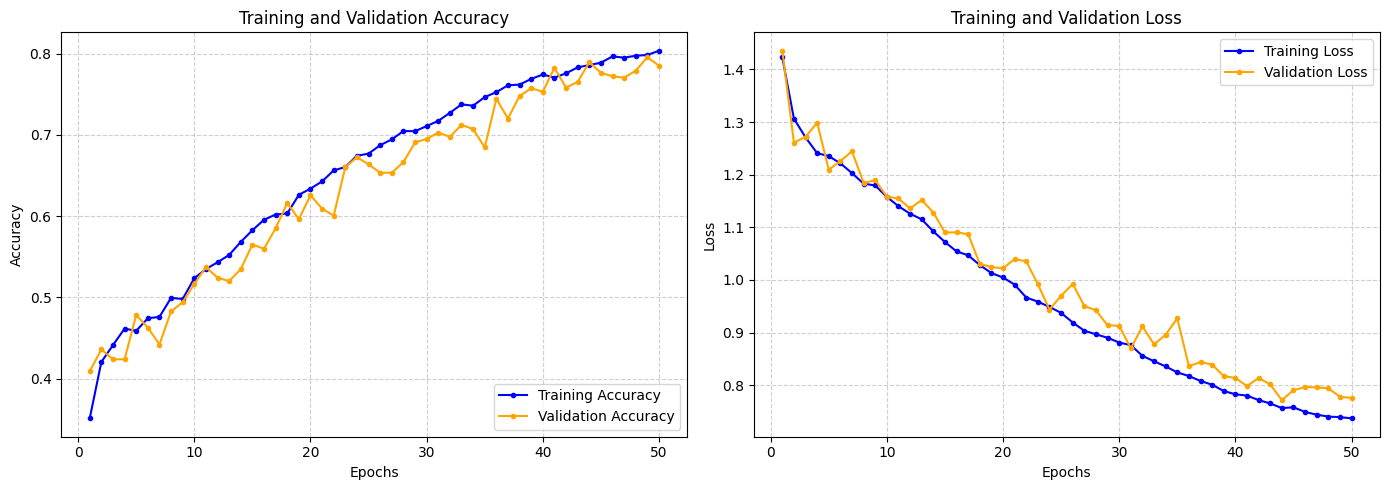

In [25]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    acc = history['train_acc']
    val_acc = history['val_acc']
    loss = history['train_loss']
    val_loss = history['val_loss']
    
    # Creiamo un array con il numero delle epoche effettive
    epochs_range = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    # --- GRAFICO 1: ACCURACY ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='blue', marker='o', markersize=3)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='orange', marker='o', markersize=3)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # --- GRAFICO 2: LOSS ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='blue', marker='o', markersize=3)
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='orange', marker='o', markersize=3)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Esegui la funzione passando la history ottenuta dal training
if 'history' in locals():
    plot_training_results(history)
else:
    print("Errore: Variabile 'history' non trovata. Assicurati che la funzione di training la restituisca.")

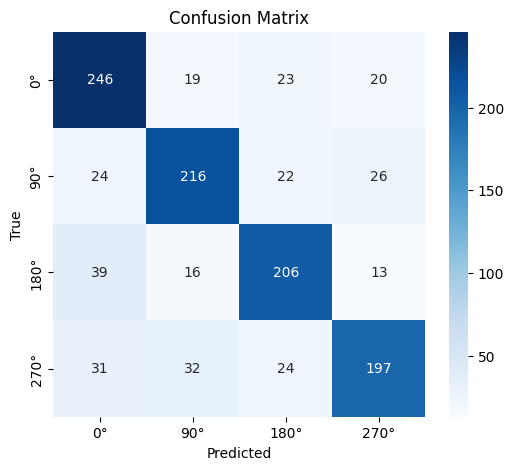

In [26]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(model, val_loader, class_names):
    y_true = []
    y_pred = []
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Move to CPU and append to lists
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot using Seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Define class names (based on your rotation angles)
class_names = ['0°', '90°', '180°', '270°']

# Run the confusion matrix function
plot_confusion_matrix(model, val_loader, class_names)

Hunting for errors: True 270° --> Pred 180°


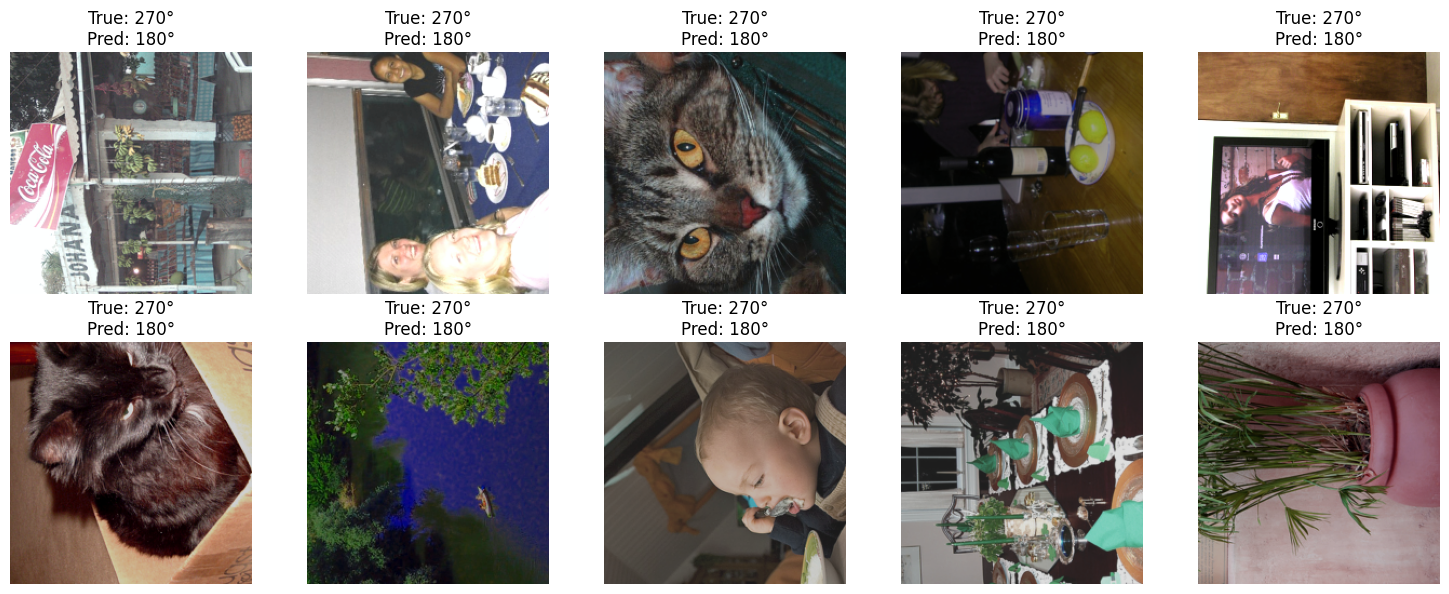

In [27]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Define the specific error we want to hunt
TRUE_CLASS = 3  # 270 degrees
PRED_CLASS = 2  # 180 degrees
NUM_IMAGES_TO_SHOW = 10

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    
    # If you used the normalization I suggested earlier, un-normalize here.
    # If you are still using the original simple transform, these values don't hurt much 
    # but strictly speaking should match your transform.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Check if image looks normalized (values < 0). If so, un-normalize.
    if np.min(inp) < 0:
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
        
    plt.imshow(inp)
    if title:
        plt.title(title)
    plt.axis('off')

def visualize_specific_errors(model, dataloader, true_label_idx, pred_label_idx, max_images=10):
    model.eval()
    images_so_far = 0
    
    # Create a figure for plotting
    plt.figure(figsize=(15, 6))
    
    print(f"Hunting for errors: True {true_label_idx*90}° --> Pred {pred_label_idx*90}°")
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            # Find indices where the specific error occurs
            # (True Label == target) AND (Predicted == target_error)
            error_idxs = (labels == true_label_idx) & (preds == pred_label_idx)
            
            # If we found any errors in this batch
            if error_idxs.sum() > 0:
                # Get the images that correspond to these errors
                error_images = inputs[error_idxs]
                
                for j in range(error_images.size(0)):
                    images_so_far += 1
                    ax = plt.subplot(2, 5, images_so_far)
                    
                    # Move image to CPU for plotting
                    img_data = error_images[j].cpu()
                    imshow(img_data, title=f"True: {true_label_idx*90}°\nPred: {pred_label_idx*90}°")
                    
                    if images_so_far == max_images:
                        plt.tight_layout()
                        plt.show()
                        return

    if images_so_far == 0:
        print("Good news! No errors of this specific type were found in the batches checked.")
    else:
        plt.tight_layout()
        plt.show()

# --- RUN THE FUNCTION ---
# Class mapping: 0=0°, 1=90°, 2=180°, 3=270°
visualize_specific_errors(model, val_loader, 
                         true_label_idx=3,  # 270°
                         pred_label_idx=2,  # 180°
                         max_images=10)